[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Before SMOTE: sentiment
Negative    20
Positive    17
Neutral     13
Name: count, dtype: int64
After SMOTE: sentiment
Negative    20
Positive    20
Neutral     20
Name: count, dtype: int64

=== Naive Bayes ===
              precision    recall  f1-score   support

    Negative       0.50      0.25      0.33         4
     Neutral       0.60      0.75      0.67         4
    Positive       0.40      0.50      0.44         4

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.48        12
weighted avg       0.50      0.50      0.48        12


=== Logistic Regression ===
              precision    recall  f1-score   support

    Negative       0.50      0.25      0.33         4
     Neutral       0.60      0.75      0.67         4
    Positive       0.40      0.50      0.44         4

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.48        12
weighted avg       0.50      0.50      0.48        12


C:\Users\HP\AppData\Local\Temp\ipykernel_14308\3068541599.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=["Negative","Neutral","Positive"], ax=axes[0], palette="Set2")
C:\Users\HP\AppData\Local\Temp\ipykernel_14308\3068541599.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, order=["Negative","Neutral","Positive"], ax=axes[1], palette="Set1")


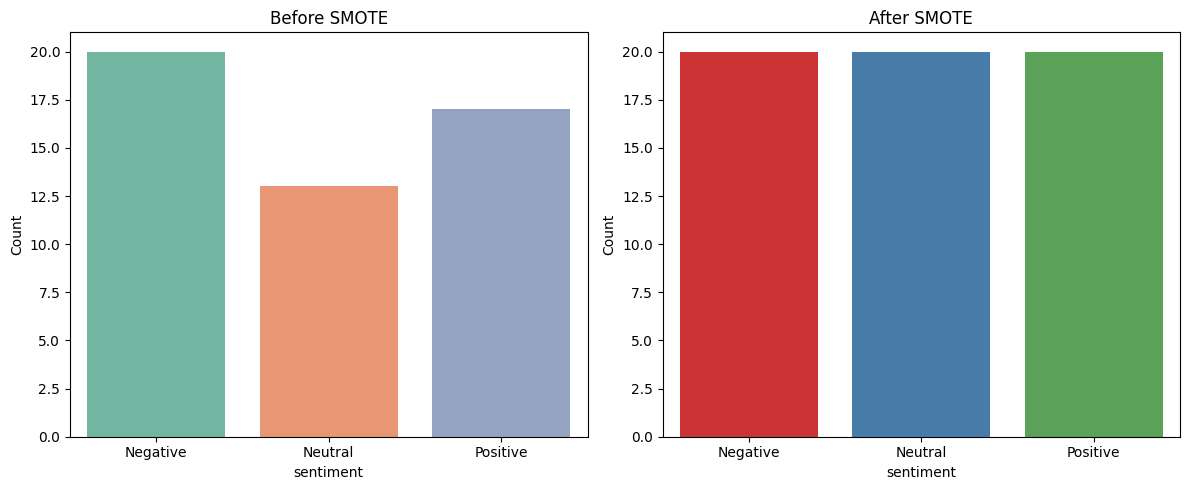

In [4]:
# ================================
# AI Echo: Sentiment Analysis Project
# ================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
)

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# ================================
# Load dataset
# ================================
df = pd.read_csv(r"C:\Users\HP\Downloads\Datascience_5th_project\chatgpt_reviews.csv")

# ================================
# Data Preprocessing
# ================================

# Fill missing reviews
df["review"] = df["review"].fillna("")

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove urls
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # keep only letters
    return text

df["cleaned_review"] = df["review"].apply(clean_text)

# Tokenization + Stopwords Removal + Lemmatization
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["processed_review"] = df["cleaned_review"].apply(preprocess_tokens)

# ================================
# Create Sentiment Labels
# ================================
def label_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["rating"].apply(label_sentiment)

# ================================
# Exploratory Data Analysis
# ================================

# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sentiment", order=["Negative","Neutral","Positive"])
plt.title("Sentiment Distribution")
plt.savefig("sentiment_distribution.png")
plt.close()

# Word clouds for positive/negative
positive_text = " ".join(df[df["sentiment"]=="Positive"]["processed_review"])
negative_text = " ".join(df[df["sentiment"]=="Negative"]["processed_review"])

wc_pos = WordCloud(width=600, height=400, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=600, height=400, background_color="black", colormap="Reds").generate(negative_text)

wc_pos.to_file("wordcloud_positive.png")
wc_neg.to_file("wordcloud_negative.png")

# ================================
# Feature Engineering
# ================================
X = df["processed_review"]
y = df["sentiment"]

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# ================================
# Balance the dataset with SMOTE
# ================================
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

# ================================
# Train-Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ================================
# Models
# ================================
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append([name, acc, prec, rec, f1])
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"conf_matrix_{name}.png")
    plt.close()

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
results_df.to_csv("model_results.csv", index=False)

print("\nModel Performance:\n", results_df)

# ================================
# Insights & Recommendations
# ================================
# Top features for Logistic Regression
logreg = models["Logistic Regression"]
feature_names = vectorizer.get_feature_names_out()
coeffs = logreg.coef_

for idx, sentiment_class in enumerate(logreg.classes_):
    top10 = np.argsort(coeffs[idx])[-10:]
    print(f"\nTop words for {sentiment_class}: {feature_names[top10]}")


    # ================================
# Visualize class balance (Before vs After SMOTE)
# ================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y, order=["Negative","Neutral","Positive"], ax=axes[0], palette="Set2")
axes[0].set_title("Before SMOTE")
axes[0].set_ylabel("Count")

# After SMOTE
sns.countplot(x=y_resampled, order=["Negative","Neutral","Positive"], ax=axes[1], palette="Set1")
axes[1].set_title("After SMOTE")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("class_balance_smote.png")
plt.show()


